In [161]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, fbeta_score, roc_curve, auc, recall_score
from imblearn.metrics import geometric_mean_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder


In [62]:
## Jakby imblearn nie działał
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [155]:
bank_data = pd.read_csv("./Data/bank_train_data.csv", index_col=0)
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,entrepreneur,single,tertiary,no,1467,yes,yes,cellular,17,nov,349,1,-1,0,unknown,no
1,25,unemployed,single,secondary,no,34,no,yes,unknown,4,jul,316,1,-1,0,unknown,no
2,53,retired,married,secondary,no,1278,yes,no,telephone,15,jul,174,3,-1,0,unknown,no
3,31,housemaid,married,unknown,yes,-6,no,yes,telephone,7,jul,94,2,-1,0,unknown,no
4,43,unemployed,married,secondary,no,3529,no,no,cellular,5,feb,169,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,55,services,divorced,primary,no,653,no,no,unknown,6,jun,800,1,-1,0,unknown,no
3160,39,blue-collar,married,unknown,no,0,no,no,cellular,2,feb,731,1,193,3,failure,no
3161,35,technician,married,secondary,no,0,no,no,cellular,14,jul,125,2,-1,0,unknown,no
3162,37,services,single,secondary,no,105,no,yes,unknown,17,jun,260,4,-1,0,unknown,no


## 1. Baseline i wybór głównych metryk (na podstawie eda)

Wcielając się w rolę pracodawcy, który zleca stworzenie modelu przewidującego czy klient złoży depozyt czy nie, uznaliśmy, że:
- Pracodawca (bank) oczekuje, że model nie będzie (w ogóle albo bardzo rzadko) się mylił co do ocenienia, że klient złoży depozyt (czyli jeśli już model przewiduje, że target=1 to rzeczywiście prawie na pewno tak jest). Oznacza to, że podczas oceny modeli jednym z głównych metryk będzie precision TP/(TP+FP), bo chcemy jak najbardziej uniknąć FalsePositives. Dlaczego? Jeśli bank potrzebuje takiego modelu, to bardzo możliwe, że po to, aby móc spróbować wcześniej podjąć jakieś ryzyko z zainwestowaniem środków, zanim te środki otrzyma. Źle by się stało, gdyby bank użył pieniędzy, których końcowo nie dostał. Naraziłby się wtedy na ryzyko płynności jego środków.
- Ponadto większość klientów (90%) nie przyjmuje oferty. Czyli mamy doczynienia z bardzo niezbalansowanym zbiorem danych pod względem naszego target. Zastosujemy zatem ponadto metrykę g-mean, która dobrze sprawdza się w tego typu przypadkach
<br/><br/>
Do metryk dorzucimy jeszcze:
- accuracy - tylko na wypadek dla zasady
- f_beta score - z paramterem beta=0.5, co ma odwozorywać, że bardziej zależy nam na precision niż na recall
- krzywą roc - ale bardziej zwracamy uwagę na "lewą" stronę wykresów

In [156]:
# Binarne na 0, 1
cols = ["default", "housing", "loan", "y"]
for col in cols:
    bank_data[col] = bank_data[col].map({"yes": 1, "no": 0})
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,entrepreneur,single,tertiary,0,1467,1,1,cellular,17,nov,349,1,-1,0,unknown,0
1,25,unemployed,single,secondary,0,34,0,1,unknown,4,jul,316,1,-1,0,unknown,0
2,53,retired,married,secondary,0,1278,1,0,telephone,15,jul,174,3,-1,0,unknown,0
3,31,housemaid,married,unknown,1,-6,0,1,telephone,7,jul,94,2,-1,0,unknown,0
4,43,unemployed,married,secondary,0,3529,0,0,cellular,5,feb,169,2,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,55,services,divorced,primary,0,653,0,0,unknown,6,jun,800,1,-1,0,unknown,0
3160,39,blue-collar,married,unknown,0,0,0,0,cellular,2,feb,731,1,193,3,failure,0
3161,35,technician,married,secondary,0,0,0,0,cellular,14,jul,125,2,-1,0,unknown,0
3162,37,services,single,secondary,0,105,0,1,unknown,17,jun,260,4,-1,0,unknown,0


In [65]:
seed=17

In [66]:
# Dzielimy ramkę na dane treningowe i testowe
X = bank_data.drop("y", axis=1)
y = bank_data["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [67]:
# Oddzielamy dane kategoryczne na razie do baselinu
non_numerical = ["job", "marital", "education", "contact", "month", "poutcome"]
X_train_nn = X_train.drop(non_numerical, axis=1)
X_test_nn = X_test.drop(non_numerical, axis=1)
X_train_nn

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous
218,32,0,604,0,1,28,95,3,-1,0
1053,53,0,25,1,0,6,266,3,-1,0
1211,40,0,212,0,0,7,176,1,-1,0
2309,38,0,1370,1,0,11,472,2,-1,0
2948,35,0,378,1,0,16,427,3,-1,0
...,...,...,...,...,...,...,...,...,...,...
1032,39,0,31,1,0,20,61,2,181,4
992,31,0,1495,1,1,23,159,3,-1,0
636,40,0,65,1,0,15,15,3,-1,0
564,50,0,606,1,0,14,673,2,-1,0


In [107]:
# Funkcja do badania podstawowych scorów do baselinu
def base_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    precision = precision_score(y_test, y_hat)
    g_mean = geometric_mean_score(y_test, y_hat)
    accuracy = accuracy_score(y_test, y_hat)
    fbeta = fbeta_score(y_test, y_hat, beta=0.5)
    recall = recall_score(y_test,y_hat)
    print("Precision score:", precision)
    print("G-mean score:   ", g_mean)
    print("Accuracy score: ", accuracy)
    print("Fbeta_score:    ", fbeta)
    print("Recall score:", recall)
    print("Confusion matrix: \n", confusion_matrix(y_test, y_hat))
    return precision, g_mean, accuracy, fbeta, recall

In [108]:
# Do plotowania krzywej roc
def plot_roc_curve(model, title_model, X_test, y_test):
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f" % roc_auc)
    plt.title("ROC for: " + str(title_model).split('(')[0])
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.show()

Base stats for:  DummyClassifier(random_state=17, strategy='most_frequent') 

Precision score: 0.0
G-mean score:    0.0
Accuracy score:  0.8846761453396524
Fbeta_score:     0.0
Recall score: 0.0
Confusion matrix: 
 [[560   0]
 [ 73   0]]


c:\Users\micha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


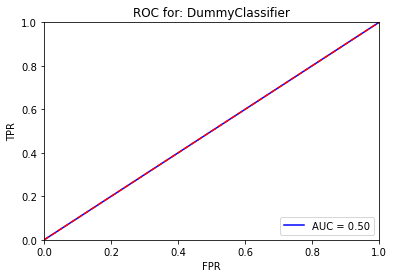

---------------------------------------------------------------
Base stats for:  LogisticRegression(max_iter=500, random_state=17) 

Precision score: 0.3684210526315789
G-mean score:    0.3063259970005095
Accuracy score:  0.8767772511848341
Fbeta_score:     0.2348993288590604
Recall score: 0.0958904109589041
Confusion matrix: 
 [[548  12]
 [ 66   7]]


c:\Users\micha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


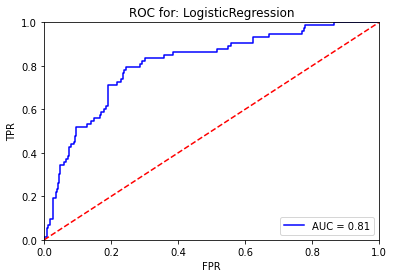

---------------------------------------------------------------
Base stats for:  DecisionTreeClassifier(random_state=17) 

Precision score: 0.35
G-mean score:    0.5898688036160685
Accuracy score:  0.8467614533965245
Fbeta_score:     0.356234096692112
Recall score: 0.3835616438356164
Confusion matrix: 
 [[508  52]
 [ 45  28]]


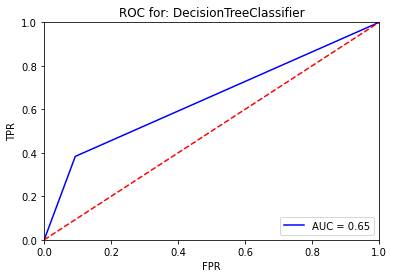

---------------------------------------------------------------
Base stats for:  SVC(kernel='linear', max_iter=5000, probability=True, random_state=17) 

Precision score: 0.16666666666666666
G-mean score:    0.6024046724856019
Accuracy score:  0.6129541864139021
Fbeta_score:     0.19457013574660634
Recall score: 0.589041095890411
Confusion matrix: 
 [[345 215]
 [ 30  43]]


c:\Users\micha\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


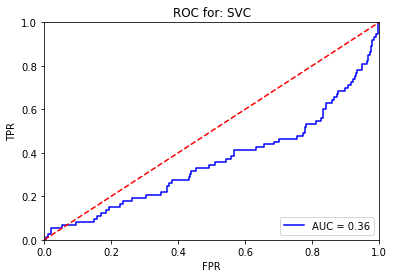

---------------------------------------------------------------
Base stats for:  GaussianNB() 

Precision score: 0.40298507462686567
G-mean score:    0.58604114787775
Accuracy score:  0.8641390205371248
Fbeta_score:     0.39589442815249265
Recall score: 0.3698630136986301
Confusion matrix: 
 [[520  40]
 [ 46  27]]


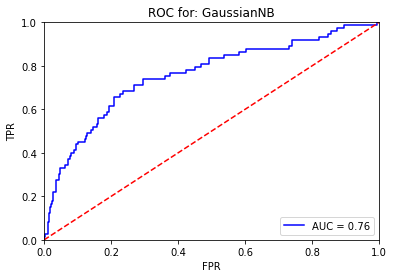

---------------------------------------------------------------


In [109]:
dc = DummyClassifier(strategy="most_frequent", random_state=seed)

lr = LogisticRegression(max_iter=500, random_state=seed)

tree1 = DecisionTreeClassifier(random_state=seed)

svm = SVC(kernel="linear", random_state=seed, max_iter=5000, probability=True)

nb = GaussianNB()

models = [dc, lr, tree1, svm, nb]

base_stats = {"precision": [], "g-mean": [], "accuracy": [], "fbeta": [], "recall": []}

for model in models:
    print("Base stats for: ", model, "\n")
    a, b, c, d, e = base_test_model(model, X_train_nn, X_test_nn, y_train, y_test)
    if model != dc:
        base_stats["precision"].append(a)
        base_stats["g-mean"].append(b)
        base_stats["accuracy"].append(c)
        base_stats["fbeta"].append(d)
        base_stats["recall"].append(e)
    plot_roc_curve(model, model, X_test_nn, y_test)
    print("---------------------------------------------------------------")


- Drzewo decyzyjne zadziałało nie najgorzej, ale można zobaczyć, że zrobił to tak jakbyśmy tego oczekiwali (nałożył duże wagi na duration i balance, czyli podobnie do tego co zakładane było w eda)
- GaussianNB też nie najgorzej

Czyli mniej więcej jakie scory chcemy przebić:
- Precision  > 0.4
- G-mean     > 0.5
- Accuracy   > 0.8 (Żeby zostało)
- F0.5_score > 0.4

In [71]:
tree1.feature_importances_

array([0.11923079, 0.00603522, 0.2041332 , 0.04087939, 0.00206469,
       0.10396017, 0.34964606, 0.04333932, 0.11123582, 0.01947534])

In [73]:
[X_train_nn.columns[2], X_train_nn.columns[6]]

['balance', 'duration']

## 2. Preprocessing

### 2.1 Zmienne numeryczne

#### 2.1.0 pdays
Korzystając z eda, pamiętamy, że prevoius było skolorowane dosyć mocno z pdays ~ 0.6, oraz previous było silniej skolerowane z targetem niż pdays. Stąd wyrzucamy pdays

In [75]:
# Klasa do wyrzucania kolumn w pipelinie
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis = 1)

In [76]:
# Sprawdzenie jak działa
column_dropper = ColumnDropper(["pdays"])
column_dropper.fit_transform(X_train_nn)

,age,default,balance,housing,loan,day,duration,campaign,previous
218,32,0,604,0,1,28,95,3,0
1053,53,0,25,1,0,6,266,3,0
1211,40,0,212,0,0,7,176,1,0
2309,38,0,1370,1,0,11,472,2,0
2948,35,0,378,1,0,16,427,3,0
...,...,...,...,...,...,...,...,...,...
1032,39,0,31,1,0,20,61,2,4
992,31,0,1495,1,1,23,159,3,0
636,40,0,65,1,0,15,15,3,0
564,50,0,606,1,0,14,673,2,0


#### 2.1.1 age

0-30     1705
30-60    1381
>60        78
Name: age, dtype: int64

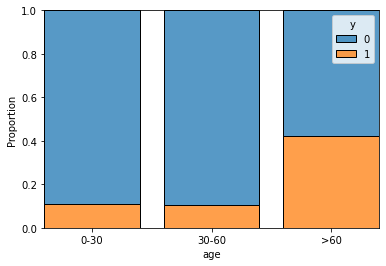

In [77]:
# Rezygnuję z tego pomysłu, za mało ludzi powyżej 60 lat
df = pd.DataFrame({"age": pd.cut(bank_data["age"], bins = [0, 40, 60, np.inf], labels=["0-30", "30-60", ">60"], duplicates = "drop"),\
      "y": bank_data["y"].copy()})
fig = sns.histplot(data = df, x = "age", hue = "y", stat = "proportion", multiple = "fill", shrink=0.8)                                                                          
df["age"].value_counts()

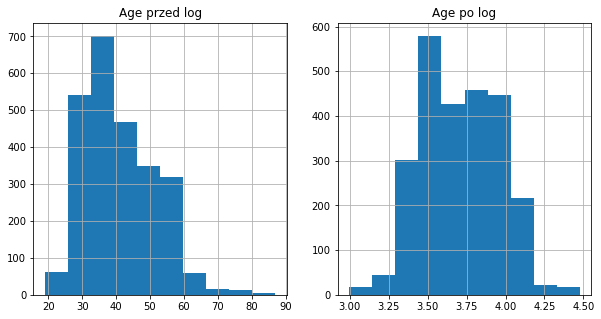

In [78]:
fig, axs = plt.subplots(1, 2)
axs = axs.flatten()
fig = X_train_nn["age"].hist(ax = axs[0], bins=10, figsize=(10, 5))
fig.set_title("Age przed log")
fig = np.log1p(X_train_nn["age"]).hist(ax = axs[1], bins=10, figsize=(10, 5))
fig.set_title("Age po log")
plt.show()

In [79]:
age_transformer = ColumnTransformer(
    [
        ("log", FunctionTransformer(np.log1p), ["age"]),
        ("standarize", StandardScaler(), ["age"])
    ]
)
age_transformer.fit_transform(X_train_nn)

array([[ 3.49650756, -0.85917206],
       [ 3.98898405,  1.14187321],
       [ 3.71357207, -0.0968691 ],
       ...,
       [ 3.71357207, -0.0968691 ],
       [ 3.93182563,  0.8560096 ],
       [ 3.8918203 ,  0.66543386]])

In [80]:
# Trochę nieefektywny, ale trudno
class LogStdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.std_scalers = [StandardScaler() for _ in range(len(columns))]
    
    def fit(self, X, y=None):
        
        for i, col in enumerate(self.columns):
            self.std_scalers[i].fit(np.log1p(X[[col]]))
            
        return self
    
    def transform(self, X, y=None):
        
        df = X.copy()
        
        for i, col in enumerate(self.columns):
            df[col] = self.std_scalers[i].transform(np.log1p(X[[col]]))
        
        return df
            
        

In [81]:
# Sprawdźmy jak działa
scaler = LogStdTransformer(["age", "duration", "campaign"])
scaler.fit_transform(X_train_nn)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous
218,-0.863196,0,604,0,1,28,-0.685210,0.447506,-1,0
1053,1.147924,0,25,1,0,6,0.413673,0.447506,-1,0
1211,0.023227,0,212,0,0,7,-0.027963,-0.916964,-1,0
2309,-0.181000,0,1370,1,0,11,1.027998,-0.118800,-1,0
2948,-0.507869,0,378,1,0,16,0.920600,0.447506,-1,0
...,...,...,...,...,...,...,...,...,...,...
1032,-0.077610,0,31,1,0,20,-1.154901,-0.118800,181,4
992,-0.988858,0,1495,1,1,23,-0.136439,0.447506,-1,0
636,0.023227,0,65,1,0,15,-2.610066,0.447506,-1,0
564,0.914507,0,606,1,0,14,1.408439,-0.118800,-1,0


#### 2.1.2 default
mała wariancja - 1.9% tylko ma ten parametr = do wywalenia

In [82]:
bank_data["default"].var()

0.018305346306235187

#### 2.1.3 balance
Wydaje się, że nie powinno obchodzić nas jak bardzo ktoś się wzbogacił, ale czy wyszedł na plusie w tym roku i czy na dużym czy na małym. W rzeczywistości dla kogoś kto ma dużo pięniędzy dodatkowe tysiące mało teoretycznie powinny zmienić

small balance > 0     1866
big balance > 1500     787
balance < 0            511
Name: balance, dtype: int64

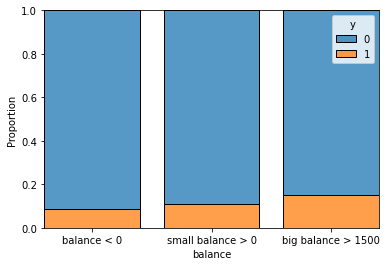

In [83]:
df = pd.DataFrame({"balance": pd.cut(bank_data["balance"], bins = [-np.inf, 0, 1500, np.inf], labels=["balance < 0", "small balance > 0", "big balance > 1500"], duplicates = "drop"),\
      "y": bank_data["y"].copy()})
fig = sns.histplot(data = df, x = "balance", hue = "y", stat = "proportion", multiple = "fill", shrink=0.8)                                                                          
df["balance"].value_counts()

In [84]:
# Klasa do pobinowania kolumny balance (Od razu mapuje do wartości 0, 1, 2)
class BalanceBinner(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        curr_balance = X["balance"]
        return X.drop("balance", axis=1).assign(balance = pd.cut(curr_balance, bins = [-np.inf, 0, 1500, np.inf], labels=[0, 1, 2]))

In [85]:
# Sprawdzenie
binner1 = BalanceBinner()
binner1.fit_transform(X_train_nn)

,age,default,housing,loan,day,duration,campaign,pdays,previous,balance
218,32,0,0,1,28,95,3,-1,0,1
1053,53,0,1,0,6,266,3,-1,0,1
1211,40,0,0,0,7,176,1,-1,0,1
2309,38,0,1,0,11,472,2,-1,0,1
2948,35,0,1,0,16,427,3,-1,0,1
...,...,...,...,...,...,...,...,...,...,...
1032,39,0,1,0,20,61,2,181,4,1
992,31,0,1,1,23,159,3,-1,0,1
636,40,0,1,0,15,15,3,-1,0,1
564,50,0,1,0,14,673,2,-1,0,1


#### 2.1.4 housing i loan
Zostawiamy na razie jako, że mogą się później przydać

#### 2.1.5 day

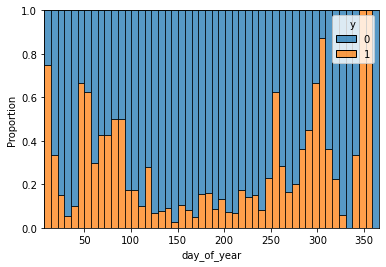

In [86]:
# Jeszcze coś sprawdzę
df = bank_data.assign(day_of_year = (pd.to_datetime(dict(year=np.repeat(2024, len(bank_data["month"])),
                    month=bank_data["month"].map({"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}),
                    day=bank_data.day))\
                    .apply(lambda x: datetime.timetuple(x).tm_yday)))
fig = sns.histplot(data = df, x = "day_of_year", hue = "y", stat = "proportion", multiple = "fill", bins = 50)
plt.show()

In [87]:
# Zwykle bez przypisywania do koła
df[["day_of_year", "y"]].corr()

,day_of_year,y
day_of_year,1.000000,0.045779
y,0.045779,1.000000


In [88]:
# Niestety przypisanie do koła nic nie daje
df.assign(day_of_year = df["day_of_year"].apply(lambda x: np.sin(x * (2 * np.pi / 365))))[["day_of_year", "y"]].corr()

,day_of_year,y
day_of_year,1.000000,-0.066057
y,-0.066057,1.000000


#### 2.1.6 duration

In [89]:
# Jak pamiętamy z edy jest to najważniejsza najprawdopodobniej cecha
bank_data[["duration", "y"]].corr()

,duration,y
duration,1.000000,0.399869
y,0.399869,1.000000


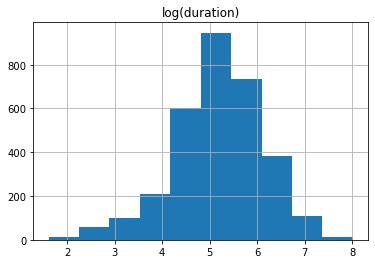

In [90]:
# Ładny zbliżony do normalnego, ale czy dalej taka dobra korelacja?
fig = np.log1p(bank_data["duration"]).hist()
plt.title("log(duration)")
plt.show()

In [91]:
# Niby trochę gorzej trzeba by potestować
bank_data.assign(duration = np.log1p(bank_data["duration"]))[["duration", "y"]].corr()

,duration,y
duration,1.000000,0.344805
y,0.344805,1.000000


In [92]:
# Można spróbować tak
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scalers = [MinMaxScaler() for i in range(len(columns))]
        
    def fit(self, X, y=None):
        for i, col in enumerate(self.columns):
            self.scalers[i].fit(X[[col]])
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        for i, col in enumerate(self.columns):
            df[col] = self.scalers[i].transform(X[[col]])
        
        return df

#### 2.1.7 campaign i previous

In [93]:
bank_data[["campaign", "previous", "y"]].corr()

,campaign,previous,y
campaign,1.000000,-0.085033,-0.064334
previous,-0.085033,1.000000,0.147231
y,-0.064334,0.147231,1.000000


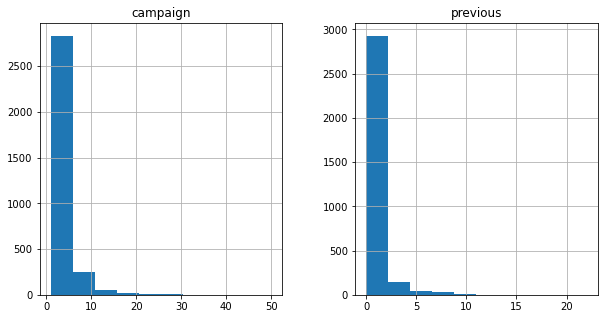

In [94]:
bank_data[["campaign", "previous"]].hist(figsize=(10, 5))
plt.show()

In [95]:
# Spróbujemy również najpierw logarytmować i potem standaryzować (znowu skośne dane)
logstd_transformer = ColumnTransformer(
    [
        ("log", FunctionTransformer(np.log1p), ["campaign", "previous"]),
        ("standarize", StandardScaler(), ["campaign", "previous"])
    ]
)
logstd_transformer.fit_transform(X_train_nn)

array([[ 1.38629436,  0.        ,  0.08175704, -0.34019134],
       [ 1.38629436,  0.        ,  0.08175704, -0.34019134],
       [ 0.69314718,  0.        , -0.57829737, -0.34019134],
       ...,
       [ 1.38629436,  0.        ,  0.08175704, -0.34019134],
       [ 1.09861229,  0.        , -0.24827017, -0.34019134],
       [ 0.69314718,  0.        , -0.57829737, -0.34019134]])

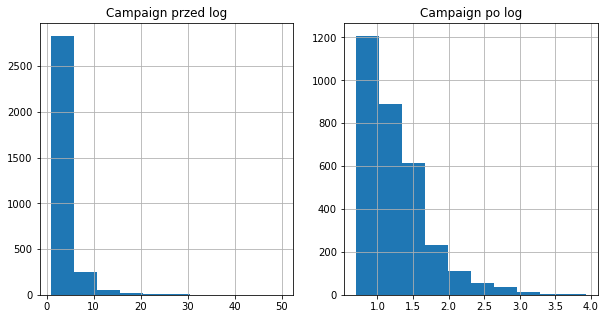

In [96]:
# Jednak trochę słabo tak robić - campaign tylko ustandaryzujemy, a previous  zbinnujemy w dwie grupy
fig, axs = plt.subplots(1, 2)
axs = axs.flatten()
fig = bank_data["campaign"].hist(ax = axs[0], bins=10, figsize=(10, 5))
fig.set_title("Campaign przed log")
fig = np.log1p(bank_data["campaign"]).hist(ax = axs[1], bins=10, figsize=(10, 5))
fig.set_title("Campaign po log")
plt.show()

In [97]:
np.where(bank_data["previous"] == 0, 0, 1)

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
class PreviousBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.assign(previous = np.where(X["previous"] == 0, 0, 1))

In [99]:
# Zobaczmy jak to na korelację wpłynęło przy okazji
pr_binner = PreviousBinner()
pr_binner.fit_transform(bank_data)[["previous", "y"]].corr()
# uu lepiej

,previous,y
previous,1.000000,0.170325
y,0.170325,1.000000


### 2.2 Zmienne numeryczne - wyniki preprocessingu

In [100]:
pipe = Pipeline([
    ("dropper", ColumnDropper(["pdays", "default"])),
    ("balance_binner", BalanceBinner()),
    ("bin_previous", PreviousBinner()),
    ("transformer", LogStdTransformer(["age", "duration", "campaign"]))
])
pipe.fit_transform(X_train_nn)

,age,housing,loan,day,duration,campaign,previous,balance
218,-0.863196,0,1,28,-0.685210,0.447506,0,1
1053,1.147924,1,0,6,0.413673,0.447506,0,1
1211,0.023227,0,0,7,-0.027963,-0.916964,0,1
2309,-0.181000,1,0,11,1.027998,-0.118800,0,1
2948,-0.507869,1,0,16,0.920600,0.447506,0,1
...,...,...,...,...,...,...,...,...
1032,-0.077610,1,0,20,-1.154901,-0.118800,1,1
992,-0.988858,1,1,23,-0.136439,0.447506,0,1
636,0.023227,1,0,15,-2.610066,0.447506,0,1
564,0.914507,1,0,14,1.408439,-0.118800,0,1


Stats with preproccessing for:  LogisticRegression(max_iter=500, random_state=17) 

Precision score: 0.35714285714285715
G-mean score:    0.2596004004351043
Accuracy score:  0.8783570300157978
Fbeta_score:     0.19379844961240308
Recall score: 0.0684931506849315
Confusion matrix: 
 [[551   9]
 [ 68   5]]


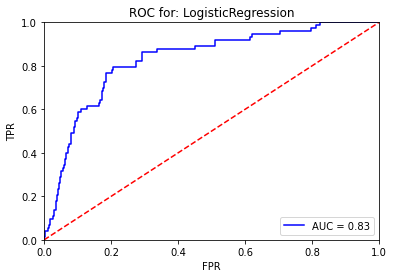

---------------------------------------------------------------
Stats with preproccessing for:  DecisionTreeClassifier(random_state=17) 

Precision score: 0.3
G-mean score:    0.51234753829798
Accuracy score:  0.8404423380726699
Fbeta_score:     0.29745042492917845
Recall score: 0.2876712328767123
Confusion matrix: 
 [[511  49]
 [ 52  21]]


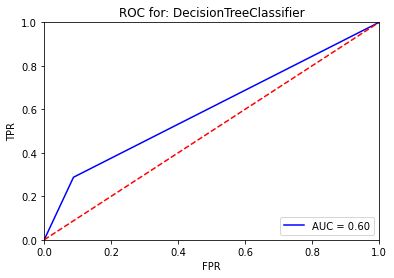

---------------------------------------------------------------
Stats with preproccessing for:  SVC(kernel='linear', max_iter=5000, probability=True, random_state=17) 

Precision score: 0.8
G-mean score:    0.23387319895581
Accuracy score:  0.8894154818325435
Fbeta_score:     0.2150537634408602
Recall score: 0.0547945205479452
Confusion matrix: 
 [[559   1]
 [ 69   4]]


c:\Users\micha\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


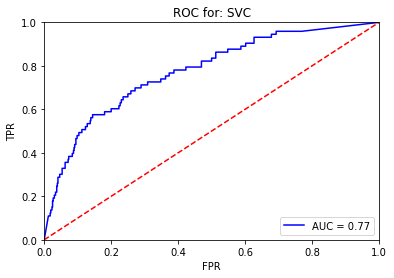

---------------------------------------------------------------
Stats with preproccessing for:  GaussianNB() 

Precision score: 0.5348837209302325
G-mean score:    0.5511951078944114
Accuracy score:  0.8894154818325435
Fbeta_score:     0.46938775510204084
Recall score: 0.3150684931506849
Confusion matrix: 
 [[540  20]
 [ 50  23]]


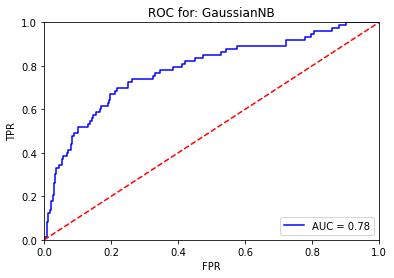

---------------------------------------------------------------


In [110]:
lr = LogisticRegression(max_iter=500, random_state=seed)

tree1 = DecisionTreeClassifier(random_state=seed)

svm = SVC(kernel="linear", random_state=seed, max_iter=5000, probability=True)

nb = GaussianNB()

preproc1_stats = {"precision": [], "g-mean": [], "accuracy": [], "fbeta": [], "recall": []}

models = [lr, tree1, svm, nb]

for model in models:
    print("Stats with preproccessing for: ", model, "\n")
    pipe = Pipeline([
    ("dropper", ColumnDropper(["pdays", "default"])),
    ("balance_binner", BalanceBinner()),
    ("bin_previous", PreviousBinner()),
    ("transformer _ age, campaign", LogStdTransformer(["age", "campaign"])),
    ("transformer _ duration", MinMaxTransformer(["duration"])),
    ("model", model)
    ])
    a, b, c, d, e = base_test_model(pipe, X_train_nn, X_test_nn, y_train, y_test)
    preproc1_stats["precision"].append(a)
    preproc1_stats["g-mean"].append(b)
    preproc1_stats["accuracy"].append(c)
    preproc1_stats["fbeta"].append(d)
    preproc1_stats["recall"].append(e)
    
    plot_roc_curve(pipe, model, X_test_nn, y_test)
    print("---------------------------------------------------------------")

Stats with preproccessing for:  LogisticRegression(max_iter=500, random_state=17) 

Precision score: 0.4482758620689655
G-mean score:    0.4159256293600007
Accuracy score:  0.8799368088467614
Fbeta_score:     0.34391534391534384
Recall score: 0.1780821917808219
Confusion matrix: 
 [[544  16]
 [ 60  13]]


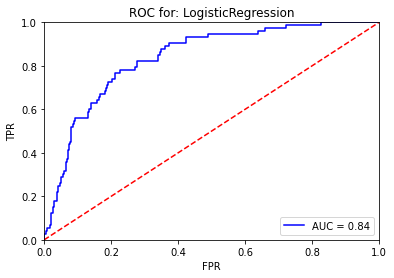

---------------------------------------------------------------
Stats with preproccessing for:  DecisionTreeClassifier(random_state=17) 

Precision score: 0.29577464788732394
G-mean score:    0.5118459742636089
Accuracy score:  0.8388625592417062
Fbeta_score:     0.29411764705882354
Recall score: 0.2876712328767123
Confusion matrix: 
 [[510  50]
 [ 52  21]]


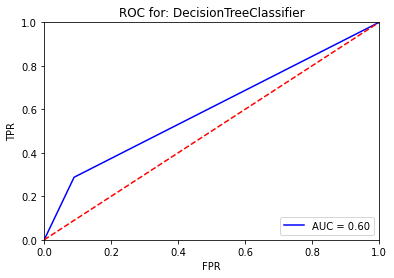

---------------------------------------------------------------
Stats with preproccessing for:  SVC(kernel='linear', max_iter=5000, probability=True, random_state=17) 

Precision score: 0.0
G-mean score:    0.0
Accuracy score:  0.8846761453396524
Fbeta_score:     0.0
Recall score: 0.0
Confusion matrix: 
 [[560   0]
 [ 73   0]]


c:\Users\micha\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\micha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


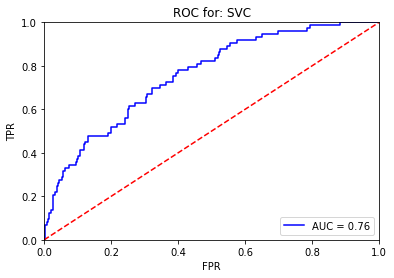

---------------------------------------------------------------
Stats with preproccessing for:  GaussianNB() 

Precision score: 0.4375
G-mean score:    0.5232603270486056
Accuracy score:  0.8751974723538705
Fbeta_score:     0.39622641509433965
Recall score: 0.2876712328767123
Confusion matrix: 
 [[533  27]
 [ 52  21]]


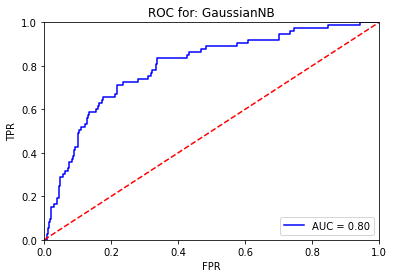

---------------------------------------------------------------


In [112]:
lr = LogisticRegression(max_iter=500, random_state=seed)

tree1 = DecisionTreeClassifier(random_state=seed)

svm = SVC(kernel="linear", random_state=seed, max_iter=5000, probability=True)

nb = GaussianNB()

preproc2_stats = {"precision": [], "g-mean": [], "accuracy": [], "fbeta": [], "recall":[]}

models = [lr, tree1, svm, nb]

for model in models:
    print("Stats with preproccessing for: ", model, "\n")
    pipe = Pipeline([
    ("dropper", ColumnDropper(["pdays", "default"])),
    ("balance_binner", BalanceBinner()),
    ("bin_previous", PreviousBinner()),
    ("transformer _ age, campaign", LogStdTransformer(["age", "campaign", "duration"])),
    ("model", model)
    ])
    a, b, c, d, e = base_test_model(pipe, X_train_nn, X_test_nn, y_train, y_test)
    preproc2_stats["precision"].append(a)
    preproc2_stats["g-mean"].append(b)
    preproc2_stats["accuracy"].append(c)
    preproc2_stats["fbeta"].append(d)
    preproc2_stats["recall"].append(e)
    plot_roc_curve(pipe, model, X_test_nn, y_test)
    print("---------------------------------------------------------------")

Stats with preproccessing for:  LogisticRegression(max_iter=500, random_state=17) 

Precision score: 0.5
G-mean score:    0.328669261364596
Accuracy score:  0.8846761453396524
Fbeta_score:     0.291970802919708
Recall score: 0.1095890410958904
Confusion matrix: 
 [[552   8]
 [ 65   8]]


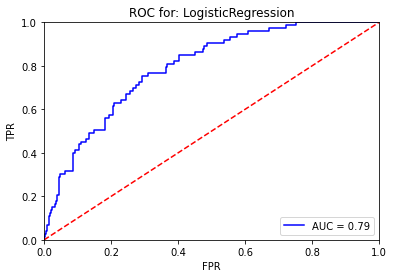

---------------------------------------------------------------
Stats with preproccessing for:  DecisionTreeClassifier(random_state=17) 

Precision score: 0.2328767123287671
G-mean score:    0.45780895698521495
Accuracy score:  0.8230647709320695
Fbeta_score:     0.23287671232876708
Recall score: 0.2328767123287671
Confusion matrix: 
 [[504  56]
 [ 56  17]]


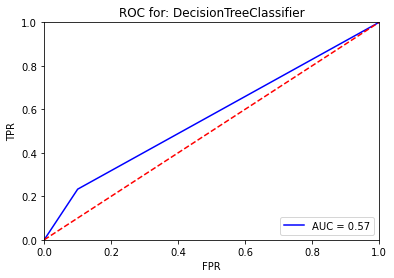

---------------------------------------------------------------
Stats with preproccessing for:  SVC(kernel='linear', max_iter=5000, probability=True, random_state=17) 

Precision score: 0.0
G-mean score:    0.0
Accuracy score:  0.8846761453396524
Fbeta_score:     0.0
Recall score: 0.0
Confusion matrix: 
 [[560   0]
 [ 73   0]]


c:\Users\micha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


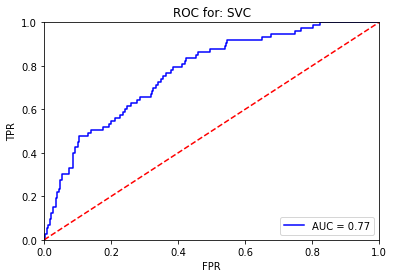

---------------------------------------------------------------
Stats with preproccessing for:  GaussianNB() 

Precision score: 0.5
G-mean score:    0.2605409846774077
Accuracy score:  0.8846761453396524
Fbeta_score:     0.22123893805309733
Recall score: 0.0684931506849315
Confusion matrix: 
 [[555   5]
 [ 68   5]]


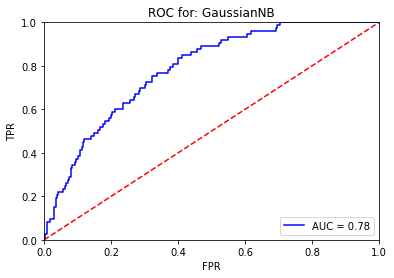

---------------------------------------------------------------


In [113]:
lr = LogisticRegression(max_iter=500, random_state=seed)

tree1 = DecisionTreeClassifier(random_state=seed)

svm = SVC(kernel="linear", random_state=seed, max_iter=5000, probability=True)

nb = GaussianNB()

preproc3_stats = {"precision": [], "g-mean": [], "accuracy": [], "fbeta": [], "recall":[]}

models = [lr, tree1, svm, nb]

for model in models:
    print("Stats with preproccessing for: ", model, "\n")
    pipe = Pipeline([
    ("dropper", ColumnDropper(["pdays", "default"])),
    ("balance_binner", BalanceBinner()),
    ("bin_previous", PreviousBinner()),
    ("transformer _ age, campaign", LogStdTransformer(["age", "campaign", "duration"])),
    ("pca", PCA(n_components=5)),
    ("model", model)
    ])
    a, b, c, d, e = base_test_model(pipe, X_train_nn, X_test_nn, y_train, y_test)
    preproc3_stats["precision"].append(a)
    preproc3_stats["g-mean"].append(b)
    preproc3_stats["accuracy"].append(c)
    preproc3_stats["fbeta"].append(d)
    preproc3_stats["recall"].append(e)
    plot_roc_curve(pipe, model, X_test_nn, y_test)
    print("---------------------------------------------------------------")

In [122]:
# base stats
df = pd.DataFrame(base_stats)
df.index = ["lr", "tree1", "svm", "nb"]
df

,precision,g-mean,accuracy,fbeta,recall
lr,0.368421,0.306326,0.876777,0.234899,0.095890
tree1,0.350000,0.589869,0.846761,0.356234,0.383562
svm,0.166667,0.602405,0.612954,0.194570,0.589041
nb,0.402985,0.586041,0.864139,0.395894,0.369863


In [123]:
# for preproccessed 1 (with duration minmax scaled)
df = pd.DataFrame(preproc1_stats)
df.index = ["lr", "tree1", "svm", "nb"]
df

,precision,g-mean,accuracy,fbeta,recall
lr,0.357143,0.259600,0.878357,0.193798,0.068493
tree1,0.300000,0.512348,0.840442,0.297450,0.287671
svm,0.800000,0.233873,0.889415,0.215054,0.054795
nb,0.534884,0.551195,0.889415,0.469388,0.315068


In [124]:
# for preproccessed 2 (with duration log then std)
df = pd.DataFrame(preproc2_stats)
df.index = ["lr", "tree1", "svm", "nb"]
df

,precision,g-mean,accuracy,fbeta,recall
lr,0.448276,0.415926,0.879937,0.343915,0.178082
tree1,0.295775,0.511846,0.838863,0.294118,0.287671
svm,0.000000,0.000000,0.884676,0.000000,0.000000
nb,0.437500,0.523260,0.875197,0.396226,0.287671


In [125]:
# for preproccessed 3 (with duration log then std then pca done)
df = pd.DataFrame(preproc3_stats)
df.index = ["lr", "tree1", "svm", "nb"]
df

,precision,g-mean,accuracy,fbeta,recall
lr,0.500000,0.328669,0.884676,0.291971,0.109589
tree1,0.232877,0.457809,0.823065,0.232877,0.232877
svm,0.000000,0.000000,0.884676,0.000000,0.000000
nb,0.500000,0.260541,0.884676,0.221239,0.068493


To samo ale ze zakodowanymi wszystkimi zmiennymi

In [191]:
bank_data = pd.read_csv("./Data/bank_train_data.csv", index_col=0)
bank_data['education'] = bank_data['education'].map({'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3})

bank_data = pd.get_dummies(bank_data, columns=['job','contact','marital','poutcome'])

binary = ["default", "housing", "loan", "y"]
for col in binary:
    bank_data[col] = bank_data[col].map({"yes": 1, "no": 0})
    
bank_data['month'] = bank_data["month"].map({"jan": 0, "feb": 1, "mar": 2, "apr": 3, "may": 4, "jun": 5, "jul": 6, "aug": 7, "sep": 8, "oct": 9, "nov": 10, "dec": 11})
bank_data['month'] = bank_data["month"].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
bank_data


,age,education,default,balance,housing,loan,day,month,duration,campaign,...,contact_cellular,contact_telephone,contact_unknown,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,37,3,0,1467,1,1,17,-8.660254e-01,349,1,...,1,0,0,0,0,1,0,0,0,1
1,25,2,0,34,0,1,4,1.224647e-16,316,1,...,0,0,1,0,0,1,0,0,0,1
2,53,2,0,1278,1,0,15,1.224647e-16,174,3,...,0,1,0,0,1,0,0,0,0,1
3,31,0,1,-6,0,1,7,1.224647e-16,94,2,...,0,1,0,0,1,0,0,0,0,1
4,43,2,0,3529,0,0,5,5.000000e-01,169,2,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,55,1,0,653,0,0,6,5.000000e-01,800,1,...,0,0,1,1,0,0,0,0,0,1
3160,39,0,0,0,0,0,2,5.000000e-01,731,1,...,1,0,0,0,1,0,1,0,0,0
3161,35,2,0,0,0,0,14,1.224647e-16,125,2,...,1,0,0,0,1,0,0,0,0,1
3162,37,2,0,105,0,1,17,5.000000e-01,260,4,...,0,0,1,0,0,1,0,0,0,1


In [192]:
X = bank_data.drop("y", axis=1)
y = bank_data["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

Stats with preproccessing for:  LogisticRegression(max_iter=500, random_state=17) 

Precision score: 0.7307692307692307
G-mean score:    0.5069719399978715
Accuracy score:  0.9036334913112164
Fbeta_score:     0.536723163841808
Recall score: 0.2602739726027397
Confusion matrix: 
 [[553   7]
 [ 54  19]]


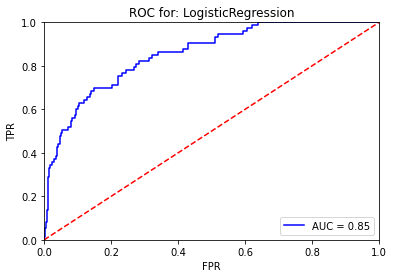

---------------------------------------------------------------
Stats with preproccessing for:  DecisionTreeClassifier(random_state=17) 

Precision score: 0.2987012987012987
G-mean score:    0.533560576180448
Accuracy score:  0.8357030015797788
Fbeta_score:     0.30183727034120733
Recall score: 0.3150684931506849
Confusion matrix: 
 [[506  54]
 [ 50  23]]


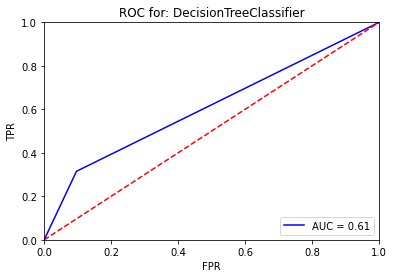

---------------------------------------------------------------
Stats with preproccessing for:  SVC(kernel='linear', max_iter=5000, probability=True, random_state=17) 

Precision score: 0.7575757575757576
G-mean score:    0.5810106586961991
Accuracy score:  0.9115323854660348
Fbeta_score:     0.6097560975609756
Recall score: 0.3424657534246575
Confusion matrix: 
 [[552   8]
 [ 48  25]]


c:\Users\micha\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


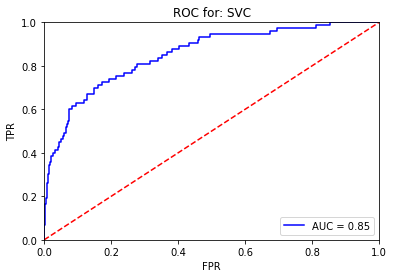

---------------------------------------------------------------
Stats with preproccessing for:  GaussianNB() 

Precision score: 0.3707865168539326
G-mean score:    0.6378474073542144
Accuracy score:  0.8483412322274881
Fbeta_score:     0.38461538461538464
Recall score: 0.4520547945205479
Confusion matrix: 
 [[504  56]
 [ 40  33]]


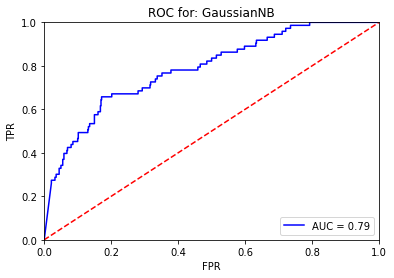

---------------------------------------------------------------


In [196]:
lr = LogisticRegression(max_iter=500, random_state=seed)

tree1 = DecisionTreeClassifier(random_state=seed)

svm = SVC(kernel="linear", random_state=seed, max_iter=5000, probability=True)

nb = GaussianNB()

preproc4_stats = {"precision": [], "g-mean": [], "accuracy": [], "fbeta": [], "recall": []}

models = [lr, tree1, svm, nb]

for model in models:
    print("Stats with preproccessing for: ", model, "\n")
    pipe = Pipeline([
    ("dropper", ColumnDropper(["pdays", "default"])),
    ("balance_binner", BalanceBinner()),
    ("bin_previous", PreviousBinner()),
    ("transformer _ age, campaign", LogStdTransformer(["age", "campaign"])),
    ("transformer _ duration", MinMaxTransformer(["duration"])),
    ("model", model)
    ])
    a, b, c, d, e = base_test_model(pipe, X_train, X_test, y_train, y_test)
    preproc4_stats["precision"].append(a)
    preproc4_stats["g-mean"].append(b)
    preproc4_stats["accuracy"].append(c)
    preproc4_stats["fbeta"].append(d)
    preproc4_stats["recall"].append(e)
    
    plot_roc_curve(pipe, model, X_test, y_test)
    print("---------------------------------------------------------------")


In [199]:
#przed encodingiem
df = pd.DataFrame(preproc1_stats)
df.index = ["lr", "tree1", "svm", "nb"]
df

,precision,g-mean,accuracy,fbeta,recall
lr,0.357143,0.259600,0.878357,0.193798,0.068493
tree1,0.300000,0.512348,0.840442,0.297450,0.287671
svm,0.800000,0.233873,0.889415,0.215054,0.054795
nb,0.534884,0.551195,0.889415,0.469388,0.315068


In [200]:
#po encodingu
df = pd.DataFrame(preproc4_stats)
df.index = ["lr", "tree1", "svm", "nb"]
df

,precision,g-mean,accuracy,fbeta,recall
lr,0.730769,0.506972,0.903633,0.536723,0.260274
tree1,0.298701,0.533561,0.835703,0.301837,0.315068
svm,0.757576,0.581011,0.911532,0.609756,0.342466
nb,0.370787,0.637847,0.848341,0.384615,0.452055


In [201]:
#bazowe statystyki
df = pd.DataFrame(base_stats)
df.index = ["lr", "tree1", "svm", "nb"]
df

,precision,g-mean,accuracy,fbeta,recall
lr,0.368421,0.306326,0.876777,0.234899,0.095890
tree1,0.350000,0.589869,0.846761,0.356234,0.383562
svm,0.166667,0.602405,0.612954,0.194570,0.589041
nb,0.402985,0.586041,0.864139,0.395894,0.369863
